# Liver Model Construction: Notebook-Glycolysis ONLY-trial

## Setup workflow

### Import packages

In [19]:
import os
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import sympy as sy
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
mass_config = MassConfiguration()

mass_config.irreversible_Keq = float("inf")

print("MASSpy version: {0}".format(mass.__version__))

import pandas as pd

from six import iteritems

import sympy as sym

import matplotlib.pyplot as plt

from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)

MASSpy version: 0.1.1


In [ ]:
pip install cplex

## Set paths and constants

In [20]:
seed = int(4)
#increase number of models from before
n_models = 20

mass_config = MassConfiguration()
mass_config.solver = "cplex"



In [ ]:
#for irreversible enzyme pair
#add reverse_flux_percent here 

### Directory paths

In [23]:
#had to remove the mass
model_dir = os.path.abspath("../models")
maps_dir = os.path.abspath("../maps")
data_dir = os.path.abspath("../data")
# add to data directory

In [24]:
# Allow Escher to close without pop-up
escher.rc['never_ask_before_quit'] = True


In [ ]:
#set conversion factor gDW --> L later function

# Create MASS model from COBRA model

### Load COBRA model

In [25]:
core_model=load_json_cobra_model(filename=os.path.join(model_dir,"CoreModel.json"))
core_model

Name,None
Memory address,0x02410ad12640
Number of metabolites,178
Number of reactions,187
Number of groups,0
Objective expression,1.0*ATPM - 1.0*ATPM_reverse_5b752
Compartments,"m, i, c, r,"


### View Escher Map


In [26]:
#view all the reactions that we need build
escher_builder = escher.Builder(
    model=core_model,
    map_json=os.path.join(
        maps_dir, ".".join((
            "Glycolysis", "map", "json"))
    ),
    highlight_missing=True)

escher_builder


Builder(highlight_missing=True, never_ask_before_quit=True)

In [27]:
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    #df = df.drop("Fasting Time", axis=1)
    #df = df.drop("Additional Notes", axis=1)
    #df = df.drop("Flux (mmol/(L*hr))", axis=1)
    #df = df.drop("Name", axis=1)
    return df

In [29]:
#define data sheet as latest data sheet
data_sheet=os.path.join(data_dir,"1.6-ma-data-collection.xlsx")

flux_df = load_data(
    filepath=data_sheet,
    sheet_name="Fluxes")
flux_df = flux_df.drop("Fasting Time", axis=1)
flux_df = flux_df.drop("Additional Notes", axis=1)
flux_df = flux_df.drop("Flux (mmol/(L*hr))", axis=1)
flux_df = flux_df.drop("Unnamed: 5", axis=1) ## weird anomaly, shouldn't happen
flux_df = flux_df.drop("Unnamed: 6", axis=1)## weird anomaly, shouldn't happen
flux_df


,Flux(mmol/(gDW*hr))
ID,
GLCter,-0.001674
G6PPer,0.001674
G6Pter,0.001674
GLPASE1,0.000215
PGMT,0.000215
EX_glygn2_c,-0.000215
GAPD,0.002903
PGK,0.002903
PGM,0.002903


In [31]:
v_vars = []
v_data = []


In [ ]:
# Set PFK/FBP irreversible enzyme pair 
#How much flux to allow through irreversible reaction pairs --> address when doing more than glycolysis
#irreversible_enzyme_pairs = ["PFK", "FBP"]

In [35]:
for rid, flux in flux_df.itertuples():
    reaction = core_model.reactions.get_by_id(rid)
    #reaction.bounds = (flux, flux)
    #set bounds for all boundary reactions 
    #uptake --> (-value, 1000)
    #secretion --> (-1000 --> value)
    #reversible --> (-1000,1000)
    if (rid == "EX_lac__L_c"): #uptake
        reaction = core_model.reactions.get_by_id(rid)
        reaction.bounds = (-1000,1000) #update first value
#    elif (rid == "EX_glc__L_c"): #secretion
#        reaction = core_model.reactions.get_by_id(rid)
#        reaction.bounds = (-1, 1000) #update second value
#    elif (rid == "EX_pyr_c"): #secretion
#        reaction = core_model.reactions.get_by_id(rid)
#        reaction.bounds = (-1000, 1) #update second value
    #elif (rid == "EX_glygn2_c"): #secretion
    #    reaction = core_model.reactions.get_by_id(rid)
    #    reaction.bounds = (-1000, 1000) #update second value
        
#address irreversible enzyme pair boundary reactions if necessary

    print(rid, flux)

    v_vars.append(sym.Symbol(rid))
    v_data.append(flux)
    
#print(v_vars)
#print(v_data)

GLCter -0.001674327221
G6PPer 0.001674327221
G6Pter 0.001674327221
GLPASE1 0.0002150512027
PGMT 0.0002150512027
EX_glygn2_c -0.0002150512027
GAPD 0.002903191236
PGK 0.002903191236
PGM 0.002903191236
ENO -0.002903191236
PEPCKm 0.004178137652
PCm 0.003794117647
LDH_L -0.002519171231
ME2 0.0006297928078
PYK 0.0006297928078
CSm 0.002995356037
MDHm 0.003379376042
EX_lac__L_c -0.001566801619


In [36]:
# Make symbolic for optlang objective 
v_vars = sym.Matrix(v_vars)
v_data = sym.Matrix(v_data)

F = sym.Matrix(2 * sym.eye(len(v_vars)))

objective = 0.5 * v_vars.T * F * v_vars  - (2 * v_data).T * v_vars
core_model.objective = objective[0]
core_model.objective_direction = "min"

flux_solution = core_model.optimize()


In [10]:
# Make adjustments to net flux of PFK/FBP to ensure
# no target flux value is 0 in order to create an enzyme module.
#performing reverse flux percent on computed values rather than measured values like the MASSpy publication
flux_solution.fluxes.FBP = flux_solution.fluxes.PFK * 0.1
flux_solution.fluxes.HEX1

0.002353417625892391

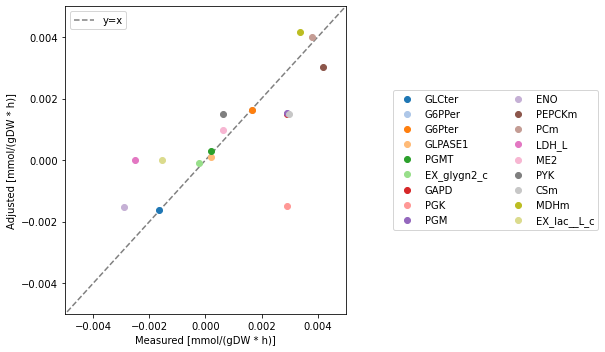

In [37]:
flux_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
plot_comparison(
    x=flux_df["Flux(mmol/(gDW*hr))"], y=flux_solution, compare="fluxes",
    observable=[rid for rid in flux_df.index], ax=ax,
    legend="right outside", plot_function="plot",
    xlim=(-0.005,0.005), ylim=(-0.005, 0.005),
    xy_line=True,
    xy_legend="best", xlabel="Measured [mmol/(gDW * h)]", ylabel="Adjusted [mmol/(gDW * h)]")

flux_comparison_fig.tight_layout()
#check directionality 


In [38]:
#for reaction in core_model.reactions:
#    print(reaction.id, reaction.check_mass_balance())


## Create MASS model

In [39]:
glycolysis = MassModel("Glycolysis", array_type='DataFrame', dtype=np.int64)
glycolysis

Name,Glycolysis
Memory address,0x0241105c1be0
Stoichiometric Matrix,0x0
Matrix Rank,0
Number of metabolites,0
Initial conditions defined,0/0
Number of reactions,0
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


### Define reactions

In [40]:
#add reactions one at a time
reaction_list = ['HEX1',
                ##'PGI',
                ##'FBP',
                #'PFK',
                #'FBA',
                #'TPI',
                #'GAPD',
                #'PGK',
                #'PGM',
                #'ENO',
                ##'PEPtm',
                ##'PEPCKm',
                ##'LDH_L',
                #'PYK'
                ##'PCm',
                ##'PYRt2m'
                ]

#commented out the ones not in glycolysis


In [41]:
#define metabolites in HEX1
#glc__D_c = MassMetabolite(
#    "glc__D_c",
#    name="D-Glucose",
#    formula="C6H12O6",
#    charge=0,
#    compartment="c",
#    fixed=False)
#atp_c = MassMetabolite(
#    "atp_c",
#    name="ATP",
#    formula="C10H12N5O13P3",
#    charge=-4,
#    compartment="c",
#    fixed=False)
#adp_c = MassMetabolite(
#    "adp_c",
#    name="ADP",
#    formula="C10H12N5O10P2",
#    charge=-3,
#    compartment="c",
#    fixed=False)
#g6p_c = MassMetabolite(
#    "g6p_c",
#    name="D-Glucose 6-phosphate",
#    formula="C6H11O9P",
#    charge=-2,
#    compartment="c",
#    fixed=False)

#h_c = MassMetabolite(
#    "h_c",
#    name="H+",
#    formula="H",
#    charge=1,
#    compartment="c",
#    fixed=False)


#add HEX1 manually

#HEX1 = MassReaction(
#    "HEX1",
#    name="Hexokinase (D-glucose:ATP)",
#    subsystem=glycolysis.id,
#    reversible=True)
#HEX1.add_metabolites({
#    glc__D_c: -1,
#    atp_c: -1,
#    adp_c: 1,
#    g6p_c: 1,
#    h_c: 1})

#set the exchange glucose flux

In [43]:
#glycolysis.add_reactions([
#    HEX1, 
    #PGI, PFK, FBA, TPI, GAPD, PGK,
    #PGM, ENO, PYK, LDH_L, ADK1, ATPM, DM_nadh
#])
#for reaction in glycolysis.reactions:
#    print(reaction)

HEX1: atp_c + glc__D_c <=> adp_c + g6p_c + h_c


In [45]:
# Convert cobra.Reactions to mass.MassReactions
for rid in reaction_list:
    reaction = core_model.reactions.get_by_id(rid)
    glycolysis.add_reactions([MassReaction(reaction)])

Ignoring reaction 'HEX1' since it already exists.


In [46]:
glycolysis.reactions.HEX1

Reaction identifier,HEX1
Name,Hexokinase (D-glucose:ATP)
Memory address,0x02410fc2c430
Subsystem,Glycolysis
Kinetic Reversibility,True
Stoichiometry,atp_c + glc__D_c <=> adp_c + g6p_c + h_c ATP + D-Glucose <=> ADP + D-Glucose 6-phosphate + H+
GPR,
Bounds,"(-1000.0, 1000.0)"


##  Set Fluxes

In [48]:
for reaction, flux in flux_solution[reaction_list].iteritems():
    reaction = glycolysis.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605 / 1000 
    # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 0.0026491647869935856


## Set Keqs

In [49]:
# Load equilibrium constants
Keq_df = pd.read_excel(engine='openpyxl',
    io=data_sheet,
    sheet_name="Keqs",
    index_col=0).drop("Reference", axis=1).drop("Stoichiometry", axis=1)

Keq_df
#Check the M units of Keq 

,Equlibrium Constant
Reaction,
CSm,5.225834e-07
ACONTm,7.157880e-02
ICDHxm,1.331211e-01
AKGDm,4.624549e+04
SUCOASm,1.592564e+00
...,...
EX_nh4_c,NaN
EX_so3_c,NaN
EX_etoh_c,NaN


In [50]:
# Set equilibrium constants
# Should we upload only the required Keqs or is this still okay 
Keq_list =[]
for rid, Keq in Keq_df.itertuples():
    if rid in reaction_list: 
        reaction = glycolysis.reactions.get_by_id(rid)
        reaction.Keq = Keq
        Keq_list.append(reaction.Keq)
        print("{0}: {1}".format(reaction.Keq_str, Keq))
        

Keq_HEX1: 2246.155176


In [ ]:
len(reaction_list) == len(Keq_list)

## Correct Metabolite Identifiers

In [52]:
#for metabolite in glycolysis.metabolites:
#    new_met_id = prefix_number_id(metabolite.id)
#    metabolite.id = new_met_id
#glycolysis.repair()

#what is the prefix_number_id function --> in the github 1.0 load_data

## Set H2O/H Constants


In [ ]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in ["h2o_c", "h_c"
                   #'h_i'
                   #'h_m'
                   #remove h_i and h_m if not mitochondrial reactions
                  ]:
    metabolite = glycolysis.metabolites.get_by_id(metabolite)
    metabolite.fixed = True


## Obtain Concentrations

In [62]:
#Load Concentration Data
conc_df = load_data(
    filepath=data_sheet,
    sheet_name="Concentrations")
#conc_df = conc_df.drop("Name", axis=1)
conc_df = conc_df.drop("Additional Notes", axis=1)
conc_df = conc_df.drop("Concentration (mM)", axis=1)

# Fix identifiers in the dataframe
#conc_df.index = [prefix_number_id(mid) for mid in conc_df.index]

In [63]:
conc_df

,Name,Concentration(M)
ID,,
13dpg_c,"3-Phospho-D-glyceroyl phosphate/ 1,3\nBisphosp...",NaN
2amac_c,2-Aminoacrylate,NaN
2pg_c,D-Glycerate 2-phosphate/ 2-\nPhosphoglycerate,0.000111
3haACP_c,NaN,NaN
3hbcoa_m,NaN,NaN
...,...,...
udp_c,UDP C9H11N2O12P2,0.000316
udpg_c,UDPglucose,0.000680
urea_c,Urea CH4N2O,0.031940


In [64]:
#Set Concentrations

metabolite_list = ['glc__D_c',
           'g6p_c',
           #'f6p_c',
           #'fdp_c',
           #'dhap_c',
           #'g3p_c',
           #'13dpg_c',
           #'3pg_c',
            #'2pg_c',
            #'pep_c',
            #'pyr_c',
            #'lac__L_c',
           #'nad_c',
            #'nadh_c',
           #'amp_c',
           'adp_c',
            'atp_c',
            #'pi_c',
            'h_c',          
            #'h2o_c',
            #'pep_m',
            #'pi_m',
            #'co2_m',
            #'gdp_m',
#           'gtp_m',
#           'oaa_m',
#           'adp_m',
#           'atp_m',
            #'h_m',
            #'hco3_m',
            #'pyr_m',
            #'h_i'
                  ]
# add later when adding other metabolites
#m=["amp_c"]
#for item in m:
#    met = core_model.metabolites.get_by_id(item)
#    glycolysis.add_metabolites([MassMetabolite(met)])

In [65]:
met_list = []
for mid, name, conc in conc_df.itertuples():
    if mid in metabolite_list: 
        metabolite = glycolysis.metabolites.get_by_id(mid)
        metabolite.name = name
        
        metabolite.ic = conc #data sheet is in M units
        met_list.append(metabolite.ic)
    
    



In [66]:
# For "pi_c", "g3p_c", "lac__D_c" use steady state literature concentrations
# Set h_c and h2o_c to 1 
for metabolite in [
    #'h_i',
    #'h_m',
    "h_c", 
    #"h2o_c"
]:
    metabolite = glycolysis.metabolites.get_by_id(metabolite)
    if metabolite.id in ["h_c" 
                         #"h2o_c"
                        ]:
        metabolite.ic = 1  #temporarily --> M Adjust number when add more compartments
    
for metabolite in glycolysis.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))
    


glc__D_c: 0.01048280703
atp_c: 0.004727145980000001
adp_c: 0.00199495195
g6p_c: 0.00014000000000000001
h_c: 1


In [ ]:
#convert nan values to None Type
#excluded_metabolites_list = []
#for metabolite in glycolysis.metabolites: 
#    if type(metabolite.ic) == None: 
#        excluded_metabolites_list.append()
#excluded_metabolites_list    

#type(glycolysis.metabolites.pyr_m.ic)


In [ ]:
# glycolysis.metabolites.h_i.ic
glycolysis.reactions.list_attr("Keq_str")

In [ ]:
len(metabolite_list) == len(glycolysis.metabolites) == len(met_list)

In [68]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    glycolysis, # bc only want metabolites in glycolysis 
    excluded_metabolites=[
        #'h_i', 'h_m', 'co2_m', 'gdp_m', 'gtp_m', 'hco3_m'
        "h_c", 
        #"h2o_c",'13dpg_c'
    ],
    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(glycolysis.fixed))
fixed_Keq_bounds=glycolysis.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution



,variables,reduced_costs
glc__D_c,0.010483,0.0
atp_c,0.004727,0.0
adp_c,0.001995,0.0
g6p_c,0.000140,0.0
Keq_HEX1,2246.155176,0.0


mass\visualization\visualization_util.py:1269 UserWarning: Ignoring {'gtp_m', 'hco3_m', 'utp_c', 'g6p_r', 'cys__L_c', 'hexACP_c', 'glygn2_c', 'akg_m', '3pg_c', 'cbp_m', 'glu__L_c', 'atp_m', 'nh4_m', 'hmgcoa_m', 'hx2coa_m', 'butACP_c', 'succ_m', 'akg_c', 'udpg_c', 'dhap_c', 'occoa_prod_c', '6pgl_c', 'acACP_c', 'asn__L_c', 'acald_c', 'citr__L_c', 'crn_c', 'mlthf_c', 'pi_m', 'glygn1_c', 'f1p_c', 'adp_m', 'bhb_m', 'dxtrn_c', 'malcoa_c', 'q10h2_m', 'r5p_c', 'arg__L_c', 'ppi_m', '13dpg_c', 'glu__L_m', '2amac_c', 'pyr_m', '3ooctACP_c', 'glc__D_r', 'pyr_c', 'orn_m', 'acald_m', 'oaa_c', '3haACP_c', '3sala_c', 'accoa_m', 'nh4_c', 'occoa_c', 'glyc3p_1octa_c', 'citr__L_m', 'glyald_c', 'lac__L_c', 'so3_c', 'acetone_m', '3ohcoa_m', 'ser__L_c', 'cit_c', 'h_c', 'pep_c', 'nad_m', 'argsuc_c', 'co2_m', 'glyc_3octa_c', '3hoctACP_c', '3snpyr_c', 'but2eACP_c', 'o2_m', 'ppi_c', 'glyc3p_2octa_c', 'hxcoa_m', 'nad_c', 'coa_c', 'fum_c', 'nadph_c', 'h2o_m', 'g1p_c', 'g3p_c', 'mlthf_m', 'h2o_r', 'c8crn_c', 'ac_m',

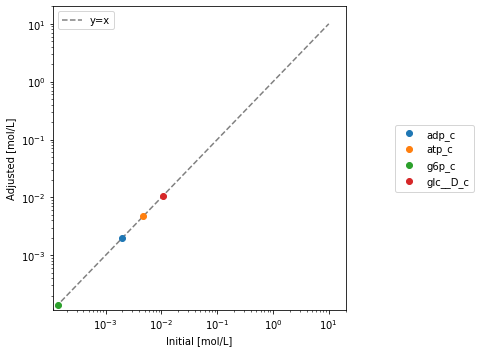

In [71]:
#Compare Results
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration(M)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(0, 20), ylim=(0, 20), xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    glycolysis, conc_solution, concentrations=True, inplace=True);

### Reset Concentrations to Computed Concentrations

In [ ]:
#Updated model with new concentrations?? 

## Sample Concentrations


In [72]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(glycolysis.fixed),
    fixed_Keq_bounds=glycolysis.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = glycolysis.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models, seed=seed)
conc_samples.head()

,glc__D_c,atp_c,adp_c,g6p_c
0,0.002409,0.003233,0.001231,0.000061
1,0.063632,0.017798,0.002881,0.000027
2,0.012468,0.004979,0.003724,0.000373
3,0.088748,0.002251,0.001311,0.000064
4,0.034836,0.001071,0.005601,0.000436


## Set concentrations and balance models with pseudoreactions


In [78]:
models_for_ensemble = []
for idx, conc_sample in conc_samples.iterrows():
    # Make copy of new model
    new_model = glycolysis.copy()
    new_model.id += "_C{0:d}".format(idx)
    # Get concentration sample and update model with sample
    new_model.update_initial_conditions(conc_sample.to_dict())

    # Determine imbalances in the reduced network
    fluxes = np.array(list(new_model.steady_state_fluxes.values()))
    imbalanced_metabolites = new_model.S.dot(fluxes)

    # Iterate through metabolites
    for mid, imbalance in imbalanced_metabolites.iteritems():
        # Ignore balanced metabolites
        if imbalance == 0:
            continue
        # Get metabolite object
        met = new_model.metabolites.get_by_id(mid)

        # Add boundary reactions for imbalanced metabolites
        boundary_type = "sink"    
        # Add boundary reaction with imbalance as flux value
        boundary_reaction = new_model.add_boundary(
            mid, boundary_type, boundary_condition=met.ic)
        
        boundary_reaction.Keq = 1
        if imbalance < 0:
            boundary_reaction.reverse_stoichiometry(inplace=True)
            imbalance = -imbalance

        boundary_reaction.kf = imbalance / met.ic
        boundary_reaction.steady_state_flux = imbalance
        try:
            # Update PERCs
            new_model.calculate_PERCs(
                fluxes={
                    r: v for r, v in new_model.steady_state_fluxes.items()
                    if not r.boundary},
                update_reactions=True)
        except:
            print("Negative PERCs for {0}".format(new_model.id))
            continue
    models_for_ensemble.append(new_model)
print("Number of models in ensemble: {0:d}".format(
    len(models_for_ensemble)))
print(models_for_ensemble)

Number of models in ensemble: 20
[<MassModel Glycolysis_C0 at 0x241174b8bb0>, <MassModel Glycolysis_C1 at 0x241184ef1c0>, <MassModel Glycolysis_C2 at 0x2411853d520>, <MassModel Glycolysis_C3 at 0x2411855bfd0>, <MassModel Glycolysis_C4 at 0x24118610e80>, <MassModel Glycolysis_C5 at 0x241186986d0>, <MassModel Glycolysis_C6 at 0x241186e7940>, <MassModel Glycolysis_C7 at 0x2411876e4f0>, <MassModel Glycolysis_C8 at 0x241187a88e0>, <MassModel Glycolysis_C9 at 0x24118845fa0>, <MassModel Glycolysis_C10 at 0x241187fb700>, <MassModel Glycolysis_C11 at 0x241198fa910>, <MassModel Glycolysis_C12 at 0x24119983520>, <MassModel Glycolysis_C13 at 0x241199d28b0>, <MassModel Glycolysis_C14 at 0x2411aa29df0>, <MassModel Glycolysis_C15 at 0x2411aa7a6d0>, <MassModel Glycolysis_C16 at 0x2411ab00880>, <MassModel Glycolysis_C17 at 0x2411ab3a4f0>, <MassModel Glycolysis_C18 at 0x2411abd7850>, <MassModel Glycolysis_C19 at 0x2411abf8be0>]


NameError: name 'Glycolysis_C0' is not defined

In [74]:
# Determine imbalances in the reduced network
fluxes = np.array(list(glycolysis.steady_state_fluxes.values()))
imbalanced_metabolites = glycolysis.S.dot(fluxes)

# Iterate through metabolites
for mid, imbalance in imbalanced_metabolites.iteritems():
    # Ignore balanced metabolites
    if imbalance == 0:
        continue
    # Get metabolite object
    met = glycolysis.metabolites.get_by_id(mid)

    # Add boundary reactions for imbalanced metabolites
    boundary_type = "sink"    
    # Add boundary reaction with imbalance as flux value
    boundary_reaction = glycolysis.add_boundary(
        mid, boundary_type, boundary_condition=met.ic)

    boundary_reaction.Keq = 1
    if imbalance < 0:
        boundary_reaction.reverse_stoichiometry(inplace=True)
        imbalance = -imbalance

    boundary_reaction.kf = imbalance / met.ic
    boundary_reaction.steady_state_flux = imbalance
    try:
        # Update PERCs
        glycolysis.calculate_PERCs(
            fluxes={
                r: v for r, v in glycolysis.steady_state_fluxes.items()
                if not r.boundary},
            update_reactions=True)
    except:
        print("Negative PERCs for {0}".format(new_model.id))
        continue

## QC/QA

In [ ]:
#qcqa_model(glycolysis, parameters=True, concentrations=True,
#           fluxes=True, superfluous=True, elemental=True)


In [ ]:
## balancing charges on reactions manually

#glycolysis.metabolites.h_c.charge=1
#glycolysis.metabolites.h_m.charge=1
#glycolysis.metabolites.h_i.charge=1
#glycolysis.metabolites.pi_c.charge=-2
#glycolysis.metabolites.pi_m.charge=-2


In [ ]:
#glycolysis.calculate_PERCs(update_reactions=True)

#print("Forward Rate Constants\n----------------------")
#for reaction in glycolysis.reactions:
#    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))


In [ ]:
#glycolysis.reactions.PGK

## Simulate Glycolysis

In [ ]:
#tfinal = 1e4
#verbose = False

#sim = Simulation(glycolysis, verbose=False)


# Setup simulation object
#sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
#conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles
#conc_sol.view_time_profile()


## Ensure model is in steady state and export

In [75]:
# Ensure all models are simulated to a long time and that
# there are enough time points to determine if model reached steady state.
tfinal = 1e4
verbose = False

sim = Simulation(reference_model=models_for_ensemble[0], verbose=verbose)
sim.add_models(models_for_ensemble[1:], verbose=verbose, disable_safe_load=True)
sim.integrator.absolute_tolerance = 1e-15
sim.integrator.relative_tolerance = 1e-9

models_to_export = []
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for model in models_for_ensemble:
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " first attempt failed.")
        # First attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 10, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " second attempt failed.")
        # Second attempt was not successful, lengthen time for second attempt
        # Attempt to determine steady state
        conc_sol, flux_sol = sim.find_steady_state(
            models=model, strategy="simulate", update_values=True,
            tfinal=tfinal * 100, 
            verbose=verbose)
        if conc_sol and flux_sol:
            continue
        print(str(model) + " third attempt failed. Eliminating model.")
        # Third attempt was not successful, eliminate the model
        sim.remove_models(models=model, verbose=verbose)

Successfully loaded MassModel 'Glycolysis' into RoadRunner.


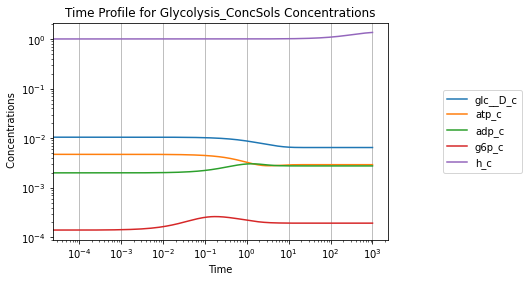

In [79]:
###RUN THIS FOR TIME PROFILE
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [ ]:
## Adding additional reactions
ADK1 = MassReaction(
    "ADK1",
    name="Adenylate kinase",
    subsystem="Misc.",
    reversible=True)

ADK = ['amp_c','atp_c']
for i in ADK:
    item = glycolysis.metabolites.get_by_id(i)
    ADK1.add_metabolites({item:1})
    
ADP =['adp_c']
for i in ADP:
    item = glycolysis.metabolites.get_by_id(i)
    ADK1.add_metabolites({item:-2})


In [ ]:
ATPM = MassReaction(
    "ATPM",
    name="ATP maintenance requirement",
    subsystem="Pseudoreaction",
    reversible=False)

ATPM_1 = ['atp_c', 'h2o_c']
ATPM_2= ['adp_c','h_c','pi_c']

for i in ATPM_1:
    item = glycolysis.metabolites.get_by_id(i)
    ATPM.add_metabolites({item:-1})
    

for i in ATPM_2:
    item = glycolysis.metabolites.get_by_id(i)
    ATPM.add_metabolites({item:1})



In [ ]:
DM_nadh = MassReaction(
    "DM_nadh",
    name="Demand NADH",
    subsystem="Pseudoreaction",
    reversible=False)

DM_nadh_1 = ['nadh_c']
DM_nadh_2= ['nad_c','h_c']

for i in DM_nadh_1:
    item = glycolysis.metabolites.get_by_id(i)
    DM_nadh.add_metabolites({item:-1})
    

for i in DM_nadh_2:
    item = glycolysis.metabolites.get_by_id(i)
    DM_nadh.add_metabolites({item:1})



In [ ]:
# Add new reactions
glycolysis.add_reactions([ADK1, ATPM, DM_nadh])

for reaction in glycolysis.reactions:
    print(reaction)

### View extracted network

In [ ]:
### NEED TO CHECK!!
escher_builder = escher.Builder(
    model=glycolysis,
    map_json=os.path.join(
        maps_dir, ".".join((
            glycolysis.id, "map", "json"))
    ),
    highlight_missing=True)

escher_builder

### Boundary Reactions

In [ ]:
SK_glc__D_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('glc__D_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_glc__D_c.reverse_stoichiometry(inplace=True)

SK_amp_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('amp_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)
SK_amp_c.reverse_stoichiometry(inplace=True)


SK_lac__L_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('lac__L_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)

SK_pyr_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('pyr_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=0.06)

SK_h_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('h_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=6.30957e-05)

SK_h2o_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('h2o_c'), boundary_type="sink", subsystem="Pseudoreaction",
    boundary_condition=1)



DM_amp_c = glycolysis.add_boundary(
    metabolite=glycolysis.metabolites.get_by_id('amp_c'), boundary_type="demand", subsystem="Pseudoreaction",
    boundary_condition=1)

print("Boundary Reactions and Values\n-----------------------------")
for reaction in glycolysis.boundary:
    boundary_met = reaction.boundary_metabolite
    bc_value = glycolysis.boundary_conditions.get(boundary_met)
    print("{0}\n{1}: {2}\n".format(
        reaction, boundary_met, bc_value))

## Simulate at steady state

In [ ]:
# Setup simulation object
sim = Simulation(glycolysis, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = sim.simulate(glycolysis, time=(0, 1e3, 1e4 + 1))
# Quickly render and display time profiles
conc_sol.view_time_profile()

# Export MASS model

In [ ]:
save_json_mass_model(
    mass_model=glycolysis,
    filename=os.path.join(model_dir, glycolysis.id + ".json"))